# Parte 1: Comenzando
## Importación de bibliotecas y configuración de entorno: 
Se importan las bibliotecas necesarias, como TensorFlow, sklearn y numpy. Además, se establece la semilla para la reproducibilidad de los resultados y se configura la variable de entorno 'PATH' para el entorno de Vivado.

In [1]:
from tensorflow.keras. utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-07-30 04:11:08.347696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 04:11:08.400227: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Obtención y preparación de datos: 
Este código carga imágenes de entrenamiento y prueba desde carpetas específicas, las redimensiona a un tamaño deseado y las almacena junto con sus etiquetas en matrices numpy para su posterior procesamiento. Los datos se dividen en imagenes (X) y etiquetas (y).

In [2]:
# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras

# Librerias de ayuda
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.11.1


In [3]:
!pip install opencv-python

import cv2
import os
import numpy as np
import pandas as pd

# Tamaño deseado para todas las imágenes
nuevo_ancho = 8
nuevo_alto = 8

# Ruta a la carpeta de imágenes
data_dir = "./signals"

# Función para cargar imágenes y etiquetas de una sola carpeta
def load_images_and_labels(directory):
    images = []
    labels = []
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path):
            for image_file in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_file)
                # Leer la imagen en escala de grises
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                # Redimensionar la imagen
                image = cv2.resize(image, (nuevo_ancho, nuevo_alto))
                # Aplanar la imagen y normalizarla
                image = image.flatten() / 255.0
                images.append(image)
                # Usar el nombre de la carpeta como etiqueta
                labels.append(folder_name)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas de la carpeta de datos
images, labels = load_images_and_labels(data_dir)

# Crear un DataFrame con las imágenes y etiquetas
df = pd.DataFrame(images)
df['label'] = labels

# Dividir en características (X) y etiquetas (y)
X = df.drop('label', axis=1)
y = df['label']

# Verificar las dimensiones de los datos cargados
print("Dimensiones de las características:", X.shape)
print("Dimensiones de las etiquetas:", y.shape)


Dimensiones de las características: (40, 64)
Dimensiones de las etiquetas: (40,)


### Imprimir información sobre el conjunto de datos: 
Imprime la forma (shape) del conjunto de datos `X` y las etiquetas `y` utilizando `X.shape` y `y.shape`. Además, imprime las primeras cinco filas de características y etiquetas utilizando `X[:5]` y `y[:5]`.

In [4]:
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

(40, 64) (40,)
         0         1         2         3         4         5         6   \
0  0.658824  0.882353  0.866667  0.737255  0.545098  0.576471  0.552941   
1  0.090196  0.317647  0.647059  0.247059  0.513725  0.266667  0.454902   
2  0.388235  0.443137  0.345098  0.364706  0.388235  0.376471  0.345098   
3  0.133333  0.082353  0.360784  0.545098  0.686275  0.372549  0.207843   
4  0.615686  0.650980  0.678431  0.643137  0.466667  0.662745  0.709804   

         7         8         9   ...        54        55        56        57  \
0  0.141176  0.435294  0.631373  ...  0.635294  0.631373  0.427451  0.427451   
1  0.529412  0.329412  0.313725  ...  0.396078  0.600000  0.341176  0.537255   
2  0.333333  0.419608  0.305882  ...  0.411765  0.650980  0.200000  0.200000   
3  0.180392  0.090196  0.525490  ...  0.623529  0.078431  0.027451  0.458824   
4  0.635294  0.631373  0.670588  ...  0.447059  0.286275  0.470588  0.541176   

         58        59        60        61        62  

En este bloque de código, se realiza la codificación de las etiquetas `y` para el entrenamiento del modelo. Primero, se utiliza `LabelEncoder()` para transformar las etiquetas de clase de cadena a numérico. Luego, se aplica `to_categorical` para convertir estas etiquetas numéricas en un formato binario "One Hot" para la clasificación multiclase. Después, se divide el conjunto de datos en conjuntos de entrenamiento y prueba utilizando `train_test_split`, con un tamaño de prueba del 20% y una semilla aleatoria de 42 para la reproducibilidad de los resultados.

Además, se realiza el escalado de las características del conjunto de datos utilizando `StandardScaler()` para asegurar que todas las características tengan una media de cero y una desviación estándar de uno, lo que puede mejorar el rendimiento del modelo. 

### Archivos creados:
Se guardan los conjuntos de datos de entrenamiento y prueba, así como las etiquetas, en archivos `.npy`, junto con la clase original de las etiquetas.
* x_train_val.npy
* x_test.npy
* y_train_val.npy
* y_test.npy
* classes.npy

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 2)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:2])

[[0. 1.]
 [0. 1.]]


In [6]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [7]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

## Construcción de modelo
Se construye un modelo de red neuronal con una capa oculta con activación ReLU, seguida de una capa de salida con activación softmax. La capa oculta tiene 128 neuronas  mientras que la capa de salida tiene 2 neuronas para clasificar en dos clases diferentes.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [9]:
model = Sequential()
model.add(Dense(64, input_shape=(64,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(2, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

2024-07-30 04:11:26.515278: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Entrenando el modelo
Utilizaremos el optimizador Adam con una pérdida de entropía cruzada categórica. Los callbacks disminuirán la tasa de aprendizaje y guardarán el modelo en un directorio llamado 'model_1'. El modelo no es muy complejo, así que esto debería tomar solo unos minutos incluso en la CPU. Si has reiniciado el kernel del notebook después de entrenar una vez, establece `train = False` para cargar el modelo entrenado.

In [10]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
1/1 [==============================] - ETA: 0s - loss: 0.7859 - accuracy: 0.5417
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 0.95130, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.95130, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

1/1 [==============================] - 1s 542ms/step - loss: 0.7859 - accuracy: 0.5417 - val_loss: 0.9513 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.5417
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 0.95130 to 0.93680, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.95130 to 0.93680, saving model to model_1/KERAS_check_best_model_weights.h5


## Evaluacion del rendimiento
Esta sección evalúa el rendimiento del modelo mediante la verificación de la precisión y la creación de una curva ROC.
Se utiliza la función accuracy_score de scikit-learn para calcular la precisión del modelo. Luego, se genera una curva ROC utilizando la función makeRoc del módulo de visualización, lo que proporciona una representación gráfica del rendimiento del modelo en diferentes umbrales de clasificación.

1/1 [==============================] - 0s 125ms/step
[[0.2933511  0.7066489 ]
 [0.35957822 0.64042175]
 [0.31835818 0.6816418 ]
 [0.669953   0.33004704]
 [0.51645446 0.4835455 ]
 [0.44127175 0.5587282 ]
 [0.6324608  0.36753926]
 [0.7072817  0.29271826]]
Accuracy: 0.875


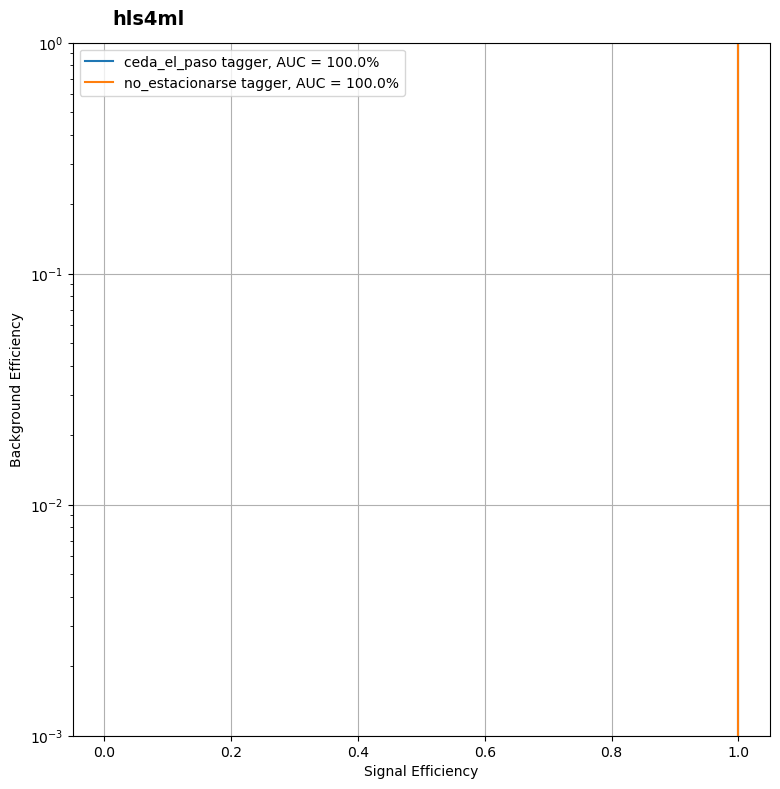

In [11]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print(y_keras)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)


## Convertir el modelo en firmware FPGA con hls4ml
Ahora pasaremos por los pasos para convertir el modelo que entrenamos en un firmware FPGA optimizado de baja latencia con hls4ml. Primero, evaluaremos su rendimiento de clasificación para asegurarnos de que no hayamos perdido precisión utilizando tipos de datos de punto fijo. Luego, sintetizaremos el modelo con Vivado HLS y verificaremos las métricas de latencia y uso de recursos de la FPGA.

### Crear una configuración y un modelo de hls4ml
La biblioteca de inferencia de redes neuronales hls4ml se controla a través de un diccionario de configuración. En este ejemplo, utilizaremos la variación más simple; en ejercicios posteriores se verán configuraciones más avanzadas.

In [12]:
!pip install torch
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc1, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:    

Visualiza la arquitectura del modelo generado por hls4ml, muestra las formas de las capas y los tipos de datos.La visualización se genera utilizando la función plot_model de hls4ml.utils.

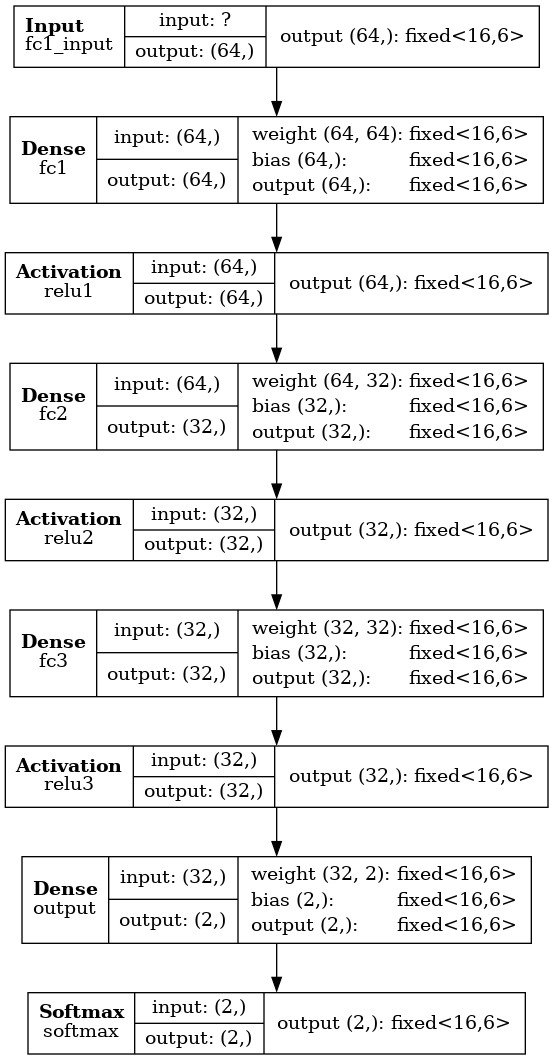

In [13]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compilar, predecir
Ahora necesitamos asegurarnos de que el rendimiento de este modelo siga siendo bueno. Compilamos el hls_model, y luego usamos hls_model.predict para ejecutar el firmware de la FPGA con emulación bit-precisa en la CPU.

In [14]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


## Comparación:
Después de comparar, calculamos la precisión de ambos modelos utilizando la función `accuracy_score` de scikit-learn. Luego, creamos un nuevo gráfico para comparar las curvas ROC de ambos modelos utilizando la función `makeRoc` del módulo `plotting`.

Keras  Accuracy: 0.875
hls4ml Accuracy: 0.875


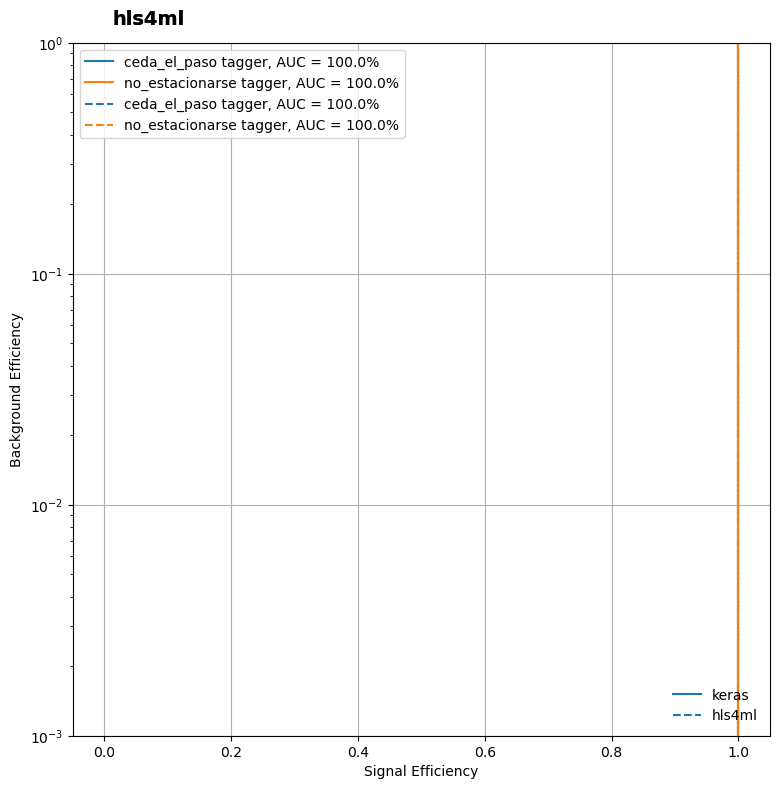

In [15]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Sintesis
Ahora vamos a utilizar Vivado HLS para sintetizar el modelo. Podemos ejecutar la construcción utilizando un método de nuestro objeto hls_model. Después de ejecutar este paso, podemos integrar el IP generado en un flujo de trabajo para compilarlo para una placa FPGA específica. En este caso, simplemente revisaremos los informes que genera Vivado HLS, verificando la latencia y el uso de recursos.

**Esto puede llevar varios minutos.**

Mientras la Síntesis en C se está ejecutando, podemos monitorear el progreso observando el archivo de registro, abriendo una terminal desde el directorio de inicio del cuaderno y ejecutando:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [16]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host 'c34b400bbab9' (Linux_x86_64 version 6.5.0-44-generic) on Tue Jul 30 04:36:17 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/HLS4ML/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/jovyan/HLS4ML/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 

{}

## Verificar los informes
Imprime los informes generados por Vivado HLS. Presta atención a las secciones de Latencia y 'Estimaciones de utilización'.

In [17]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
Synthesis report not found.
Co-simulation report not found.
